# Домашнее задание 5. Линейные модели

In [2]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
import sklearn.model_selection as sms
import seaborn as sns
import tqdm
from collections import OrderedDict
from sklearn.preprocessing import normalize
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/yura/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Зачитываем результат 4 домашки

In [3]:
data = np.load("out_4_own.dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [4]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [23]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]

test_users = df_users_ex["uid"].values
ix = np.in1d(users, test_users).reshape(users.shape)
X_test = X_dataset[np.where(ix)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [6]:
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x300903) feature matrix, 7199 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

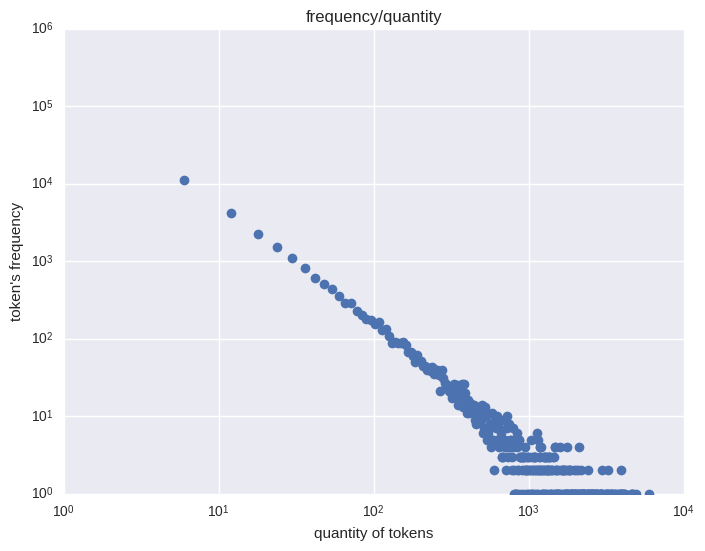

In [7]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    sums = np.sum(X > 0,axis = 0)
    sums = np.ravel(sums)
    hist = np.histogram(sums,bins = 1000)
    
    plt.figure(figsize = (8,6))
    plt.loglog(hist[1][:-1],hist[0],'o')
    plt.ylabel('token\'s frequency')
    plt.xlabel('quantity of tokens')
    plt.title('frequency/quantity')
    # Your code here
    feature_counts = sums
    return feature_counts

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [32]:
X1 = X.tocsc()[:, (features_counts > 100)].toarray()
X2 = X_test.tocsc()[:, (features_counts > 100)].toarray()

In [33]:
ones = np.ones(X1.shape[0])
X1 = np.column_stack((ones,X1))
X1 = normalize(X1,axis = 0, norm = 'max')
print X1.shape

(7199, 3471)


In [34]:
ones = np.ones(X2.shape[0])
X2 = np.column_stack((ones,X2))
X2 = normalize(X2,axis = 0, norm = 'max')
print X2.shape

(4748, 3471)


Вариант задания генерируется на основании вашего ника в техносфере.

In [10]:
USER_NAME = "b.yakimov"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [11]:
class LogisticRegression():
    """Newton method with L2 regularization"""
    def __init__(self, C = 0.1, alpha = 1.,eps = 5e-4, max_iters = 20):
        self.C = C
        self.eps = eps
        self.cost_function = []
        self.alpha = alpha
        self.max_iters = max_iters
        self.res_theta = None
    
    def calc_h(self,X,theta):
        z = np.dot(X, theta)
        h = 1./(1. + np.exp(-z))
        return h

    def calc_J(self,X,y,theta,C):
        h = self.calc_h(X,theta)
        ones = np.ones(self.N)
        ones[0] = 0
        J = -(1./self.M)*np.sum(y*np.log(h) + (1 - y)*np.log(1 - h)) + C*np.sum((ones*theta)**2)
        return J

    def calc_grad(self,X,y, theta,C):
        h = self.calc_h(X,theta)
        ones = np.ones(self.N)
        ones[0] = 0
        gradient = (1./self.M)*(np.dot(X.T, h - y)) + C*ones*theta
        return gradient

    def calc_hess(self,X,theta,C):
        h = self.calc_h(X,theta)
        ones = np.ones(self.N)
        ones[0] = 0
        A = np.transpose(X)*h*(1.-h)
        hessian = (1./self.M)*np.dot(A,X) + C*ones*np.eye(self.N)
        return hessian


    def fit(self, X, y, type_calc = 'lstsq'):
        self.M,self.N = X.shape #M samples, N features
        convergence = False
        theta = np.random.uniform(low = -1,high = 1,size = self.N)
        
        while not convergence:
            J = self.calc_J(X,y,theta,self.C)
            self.cost_function.append(J)
            
            grad = self.calc_grad(X,y,theta, self.C)
            hessian = self.calc_hess(X,theta,self.C)
            if type_calc == 'pinv':
                inverse_hess = np.linalg.pinv(hessian)
                new_theta = theta - self.alpha*np.dot(inverse_hess,grad)
            if type_calc == 'lstsq':
                d = np.linalg.lstsq(hessian,grad)[0]
                new_theta = theta - self.alpha*d
            
            new_J = self.calc_J(X,y,new_theta,self.C)
            convergence = (np.sum((new_theta - theta)**2) < self.eps) or (np.abs(new_J - J) < self.eps) 

            
            if new_J - J >= 0:
                print "New cost function is greater then the last one"
                break
            if len(self.cost_function) > self.max_iters:
                print 'iteration limit'
                break
            if convergence:
                if (np.sum((new_theta - theta)**2) < self.eps):
                    print "it's converged by theta!"
                if (np.abs(new_J - J) < self.eps):
                    print "it's converged by cost function"
                break
            theta = new_theta
            
        self.res_theta = theta
        return self
    
    def plot_cost_function(self):
        if len(self.cost_function) != 0 :
            plt.plot(range(len(self.cost_function)),self.cost_function,'o')
            plt.xlabel('iteration step')
            plt.ylabel('$J( \\theta)$')
            plt.xticks(range(len(self.cost_function)))
            plt.savefig('costfunc.png')
        
    
    def predict_proba(self, X,thrshld = 0.5):
        """function returns predicted Y for given threshold thrshld
        and probability"""
        if not(self.res_theta is None):
            probability = self.calc_h(X,self.res_theta)
            y_predicted = probability > thrshld
            return np.vstack((y_predicted,probability))
        else:
            print "Try to use fit first"
            return None
        pass

In [12]:
import sklearn.datasets

Сравним на ирисах классификацию

In [13]:
X1_iris = sklearn.datasets.load_iris()['data'][:100]
X1_iris = np.column_stack((np.ones(100),X1_iris))
X1_iris = normalize(X1_iris,norm = 'max')
Y1_iris = sklearn.datasets.load_iris()['target'][:100]

New cost function is greater then the last one
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 968 µs
New cost function is greater then the last one
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 783 µs
accuracy: 1.0
precision: 1.0


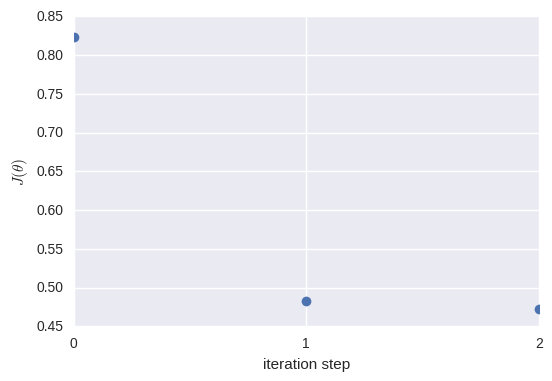

In [14]:
cls = LogisticRegression(max_iters = 50,eps = 1e-5,alpha = 1., C = 0.01)
%time cls.fit(X1_iris,Y1_iris,type_calc = 'pinv')
del cls
cls = LogisticRegression(max_iters = 50,eps = 1e-5,alpha = 1., C = 0.01)
%time cls.fit(X1_iris,Y1_iris,type_calc = 'lstsq')
cls.plot_cost_function()
print "accuracy:",sm.accuracy_score(Y1_iris,cls.predict_proba(X1_iris,thrshld=0.5)[0])
print "precision:",sm.precision_score(Y1_iris,cls.predict_proba(X1_iris,thrshld=0.5)[0])

In [15]:
def auroc(y_prob, y_true):
    """this function returns AUROC, TPR, FPR 
    for predicted probability y_prob and true labels of objects y_true"""
    auroc_value = 0.
    TPR = []
    FPR = []
    #t_range = (np.sort(y_prob)[:-1] + np.sort(y_prob)[1:])/2.
    t_range = np.linspace(0.0,1.0, num = len(y_prob))
    for t in t_range:
        y_pred = y_prob >= t
        TP = np.sum( (y_pred== True)&(y_true > 0.5))
        FN = np.sum((y_pred == False)&y_true > 0.5)
        FP = np.sum((y_pred == True)&(y_true < 0.5))
        TN = np.sum((y_pred == False)&(y_true < 0.5))
        
        TPR.append(float(TP)/(TP + FN))
        FPR.append(float(FP)/(FP + TN))

    auroc_value = -np.trapz(np.array(TPR),x= np.array(FPR))
    return auroc_value,TPR,FPR



New cost function is greater then the last one
accuracy score: 0.955
auroc is : 0.98545
sklearn auroc: 0.9856


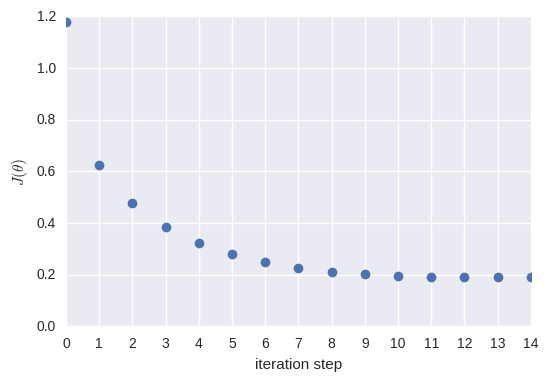

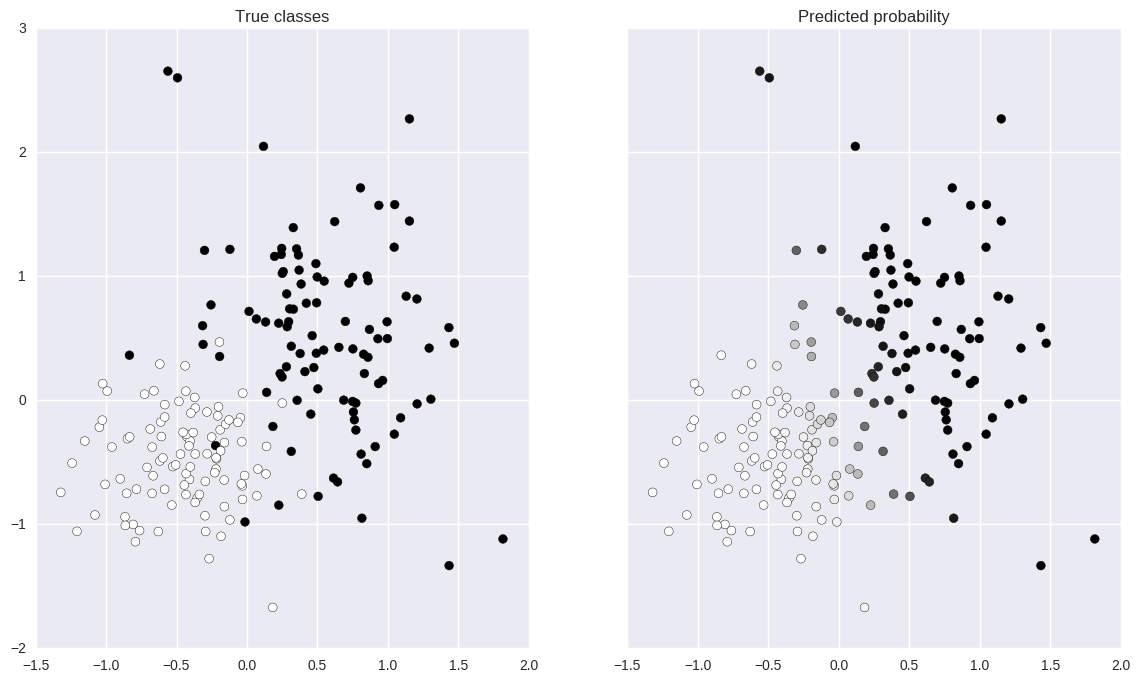

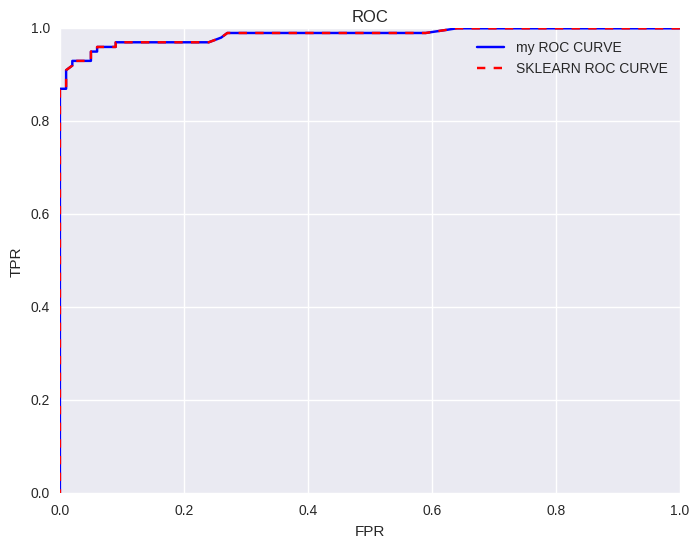

In [16]:
cls = LogisticRegression(max_iters = 100,eps = 1e-4,alpha = 0.5, C = 0.01)
def test_cls(cls):
    x1_a = np.random.normal(loc = 0.5, scale = 0.5,size = 100)
    x2_a = np.random.normal(loc = 0.5, scale = 0.75,size = 100)
    y1_a = np.array([1]*100)

    x1_b = np.random.normal(loc = -0.5, scale = 0.35,size = 100)
    x2_b = np.random.normal(loc = -0.5, scale = 0.4,size = 100)
    y1_b = np.array([0]*100)

    X_a= np.vstack((x1_a,x2_a)).T
    X_b = np.vstack((x1_b,x2_b)).T
    X = np.vstack((X_a,X_b))
    Y = np.hstack((y1_a,y1_b))


    cls = LogisticRegression(max_iters = 100,eps = 1e-4,alpha = 0.3, C = 0.01)
    cls.fit(X,Y)
    cls.plot_cost_function()
    y_pred = cls.predict_proba(X)
    f,(ax1,ax2) = plt.subplots(1,2,sharey = True,figsize = (14,8))
    ax1.scatter(X.T[0],X.T[1],c = Y,s = 40)
    ax1.set_title("True classes")
    ax2.set_title("Predicted probability")
    ax2.scatter(X.T[0],X.T[1],c = y_pred[1],s = 40)
    print "accuracy score:", sm.accuracy_score(Y,y_pred[0])
    
    
    AUROC,TPR,FPR = auroc(y_pred[1],Y)
    
    plt.figure(figsize = (8,6))
    plt.plot(FPR,TPR,'b-',label = 'my ROC CURVE')
    

    
    fpr,tpr,thrshlds = sm.roc_curve(Y,y_pred[1])
    plt.plot(FPR,TPR,'r--',label = 'SKLEARN ROC CURVE')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc = 'best')
    plt.title("ROC")
    print "auroc is :",AUROC
    print "sklearn auroc:", sm.roc_auc_score(Y,y_pred[1],'macro')

test_cls(cls)

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [58]:
C = [0.0,0.001, 0.01, 0.1, 1.,10.]

def select_reg_parameter(C, X, Y):
    best_score = 0
    best_c = -1
    index = -1
    for c in tqdm.tqdm(C):
        X_train, X_test,y_train, y_test = sms.train_test_split(X,Y,test_size = 0.33)
        cls = LogisticRegression(C = c)
        %time cls.fit(X_train,y_train)
        probability = cls.predict_proba(X_test)[1]
        auroc_score = auroc(probability,y_test)[0]
        print "score:", auroc_score
        print "sklearn roc_auc:", sm.roc_auc_score(y_test,probability)
        if auroc_score > best_score:
            best_c = c
            best_score = auroc_score
    print "best C is:", best_c
    print "best auroc is:", best_score
    return C.index(best_c)

index = select_reg_parameter(C, X1, Y)
print index

 17%|█▋        | 1/6 [01:31<07:39, 91.84s/it]

it's converged by theta!
CPU times: user 5min 48s, sys: 1.49 s, total: 5min 49s
Wall time: 1min 31s
score: 0.190803880447
sklearn roc_auc: 0.498074298408


 33%|███▎      | 2/6 [02:25<05:21, 80.46s/it]

New cost function is greater then the last one
CPU times: user 3min 19s, sys: 860 ms, total: 3min 20s
Wall time: 53.7 s
score: 0.56813481345
sklearn roc_auc: 0.56824045574


 50%|█████     | 3/6 [03:19<03:37, 72.59s/it]

New cost function is greater then the last one
CPU times: user 3min 20s, sys: 740 ms, total: 3min 21s
Wall time: 54 s
score: 0.579392636933
sklearn roc_auc: 0.580168770012


 67%|██████▋   | 4/6 [03:59<02:05, 62.67s/it]

it's converged by theta!
it's converged by cost function
CPU times: user 2min 27s, sys: 516 ms, total: 2min 28s
Wall time: 39.3 s
score: 0.552787084413
sklearn roc_auc: 0.553053894692


 83%|████████▎ | 5/6 [04:41<00:56, 56.46s/it]

it's converged by theta!
it's converged by cost function
CPU times: user 2min 32s, sys: 668 ms, total: 2min 33s
Wall time: 41.8 s
score: 0.563246919321
sklearn roc_auc: 0.566804759992


100%|██████████| 6/6 [05:20<00:00, 51.27s/it]

it's converged by theta!
it's converged by cost function
CPU times: user 2min 27s, sys: 536 ms, total: 2min 27s
Wall time: 39 s
score: 0.54034808543
sklearn roc_auc: 0.576557777377
best C is: 0.01
best auroc is: 0.579392636933
2


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

New cost function is greater then the last one
sklearn roc auc score: 0.581627030539
Area under the ROC curve : 0.581959


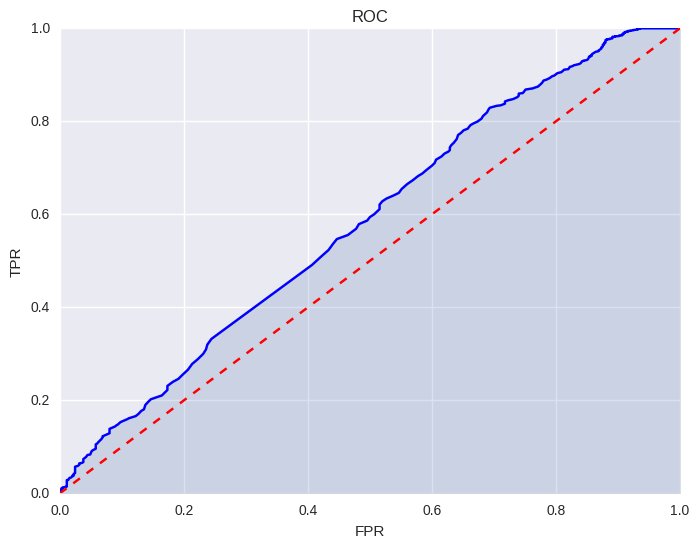

In [63]:
def classify(X, Y, test_size, C):
    X_train, X_test,y_train, y_test = sms.train_test_split(X,Y,test_size = test_size)
    cls = LogisticRegression(C = C)
    cls.fit(X_train,y_train)
    probability = cls.predict_proba(X_test)[1]
    roc_auc,tpr, fpr = auroc(probability,y_test)
    print "sklearn roc auc score:", sm.roc_auc_score(y_test,probability)
    
    return tpr, fpr, roc_auc,cls

tpr, fpr, roc_auc,cls = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr,'b-')
    plt.plot(fpr,fpr,'r--')
    plt.fill_between(fpr,tpr,alpha = 0.2)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title("ROC")
    # Your code here
    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.

In [64]:
cls.predict_proba(X2)[1]

array([ 0.77775678,  0.76615634,  0.77408038, ...,  0.77152763,
        0.7513696 ,  0.7759005 ])

In [65]:
test_submission = pd.read_csv('test_submition.csv')
test_submission.head()

,uid,cls
0,783836768,0.832747
1,3064065145,0.627585
2,25568299,0.852148
3,19238906,0.664027
4,4187257341,0.834140


In [54]:
submission = pd.DataFrame(test_users,index = range(len(test_users)),columns = ['uid'])
submission['cls'] = cls.predict_proba(X2)[1]

In [69]:
test_submission['cls'] = cls.predict_proba(X2)[1]

In [71]:
test_submission.to_csv('my_submission.csv',index = False)